# HCKT06 - Real World Model Deployment

In [1]:
import os
import pandas as pd
import numpy as np
import io
import json
import pickle
import requests
import joblib
import math
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import precision_score, recall_score, precision_recall_curve
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp
import seaborn as sns
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score

# for evaluation purposes
import hashlib
from plotchecker import LinePlotChecker, ScatterPlotChecker, BarPlotChecker

def _hash(s):
    return hashlib.blake2b(
        bytes(str(s), encoding='utf8'),
        digest_size=5
    ).hexdigest()

In [2]:
# Load Data

In [3]:
def load_data(file):
    df = pd.read_csv(os.path.join("data", file))
    return df
df_original = load_data("train.csv")
#df_new = load_data("bank_new_observations.csv")
target='Inspection Outcome'
df_original.head()

import sqlalchemy

username = 'postgres'
password = 'tsKVMTUOHtCZpVQYPtRbvkBdzmABPbDV'
host_name = 'roundhouse.proxy.rlwy.net'
port = 54090
db_name = 'railway'

conn_str = 'postgresql://{}:{}@{}:{}/{}'.format(username,password,host_name,port,db_name)
engine = sqlalchemy.create_engine(conn_str)
query = 'SELECT * FROM prediction;'
data_server = pd.read_sql_query(query, engine)

df = data_server.copy()
df_ = pd.DataFrame()
for i in range(len(df['observation'])):
    new = pd.DataFrame([json.loads(df['observation'][i])])
    df_=pd.concat([df_,new])
df_=df_.reset_index().drop(columns=['index'])
df_['Inspection Outcome']=data_server['label']

#df_original['new'] = False
#df_['new'] = True
concatenated_df = pd.concat([df_original, df_])
final_df = concatenated_df.drop_duplicates(subset='observation_id', keep='last')
#final_df.set_index('observation_id', inplace = True)
final_df


/tmp/ipykernel_2938/193134250.py:26: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_=pd.concat([df_,new])


,observation_id,Type,Date,Part of a standard enforcement protocol,Galactic X,Galactic Y,Reproduction,Age range,Self-defined species category,Officer-defined species category,Governing law,Object of inspection,Inspection involving more than just outerwear,Enforcement station,Inspection Outcome
0,8ca4b11e-2814-42ab-b8e9-bf467d6f9bc1,Entity inspection,2239-12-14 13:22:00+00:00,False,8.528523,-1398.677772,Asexual,Senior,Zoltrax - Diverse Clans,Zoltrax,Galactic Enforcement and Evidence Code 3984 (C...,Vandalism Tools,NaN,Galactic Hub X101-IO,False
1,93930d11-d5cc-46a0-91eb-96fea69eea2f,Entity and Spaceship search,2241-06-07 14:00:00+00:00,False,23.330735,-3826.240540,Asexual,Adult,Zoltrax - Diverse Clans,Silicar,Interstellar Substance Control Ordinance 4719 ...,Regulated Star Substances,NaN,Galactic Hub X101-IO,False
2,b68b83bc-9eba-484b-9369-9707132592c8,Entity inspection,2241-09-17 15:30:00+00:00,NaN,-128.358204,21050.745456,Sexual,Adult,Terran - Northern Cluster,Terran,Interstellar Substance Control Ordinance 4719 ...,Regulated Star Substances,False,Helios Command C210-ZR,True
3,2bdea27c-2168-4884-9bda-68a862aea7e1,Entity and Spaceship search,2241-10-11 08:10:00+00:00,True,126.623742,-20766.293688,Asexual,Adult,Terran - Northern Cluster,Terran,Interstellar Substance Control Ordinance 4719 ...,Regulated Star Substances,False,Krypton Dock D175-WU,False
4,c8782f5f-1c50-4710-a129-d495a404c1c3,Entity and Spaceship search,2240-05-01 20:40:00+00:00,False,-23.578062,3866.802168,Asexual,Young Adult,Zoltrax - Diverse Clans,Zoltrax,Interstellar Substance Control Ordinance 4719 ...,Regulated Star Substances,NaN,Galactic Hub X101-IO,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
432,4fa575f3-07ad-4572-96c4-a7b7444afa58,Entity inspection,2240-04-22 02:10:00+00:00,False,NaN,NaN,Asexual,Adult,Terran - Outer Colonies,Terran,Galactic Enforcement and Evidence Code 3984 (C...,Prohibited Combat Implements,None,Galactic Hub X101-IO,True
433,dc1a791f-f284-42b8-9a07-873850264e61,Entity inspection,2241-02-02 21:27:00+00:00,False,-21.399213,3509.470932,Sexual,Young Adult,Zoltrax - Diverse Clans,Zoltrax,Interstellar Substance Control Ordinance 4719 ...,Regulated Star Substances,None,Galactic Hub X101-IO,True
434,b05a7af2-bfbd-4cac-9f75-2b0a82726b48,Entity inspection,2241-06-06 12:05:00+00:00,False,-439.833411,72132.679404,Asexual,Adult,Terran - Northern Cluster,Terran,Galactic Enforcement and Evidence Code 3984 (C...,Prohibited Combat Implements,False,Graviton Manor Z54-VL,True
435,df19e5e4-8103-4f13-9b03-a2892ac9cd2f,Entity inspection,2241-04-13 20:15:58+00:00,None,-485.084065,79553.786660,Asexual,Young,Xenar - Unspecified,Terran,Interstellar Substance Control Ordinance 4719 ...,Regulated Star Substances,False,Mercury Base R525-VN,True


In [4]:
final_df.info()
#df_['Inspection Outcome'].unique()

<class 'pandas.core.frame.DataFrame'>
Index: 4493 entries, 0 to 436
Data columns (total 15 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   observation_id                                 4493 non-null   object 
 1   Type                                           4493 non-null   object 
 2   Date                                           4493 non-null   object 
 3   Part of a standard enforcement protocol        3323 non-null   object 
 4   Galactic X                                     3736 non-null   float64
 5   Galactic Y                                     3736 non-null   float64
 6   Reproduction                                   4493 non-null   object 
 7   Age range                                      4493 non-null   object 
 8   Self-defined species category                  4457 non-null   object 
 9   Officer-defined species category               4493 non-nu

In [5]:
df_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4063 entries, 0 to 4062
Data columns (total 15 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   observation_id                                 4063 non-null   object 
 1   Type                                           4063 non-null   object 
 2   Date                                           4063 non-null   object 
 3   Part of a standard enforcement protocol        3065 non-null   object 
 4   Galactic X                                     3373 non-null   float64
 5   Galactic Y                                     3373 non-null   float64
 6   Reproduction                                   4063 non-null   object 
 7   Age range                                      4063 non-null   object 
 8   Self-defined species category                  4030 non-null   object 
 9   Officer-defined species category               4063 

In [6]:
# Prepare a summary of the dataset
summary = {
    'Column Name': df_original.columns,
    'Data Type': df_original.dtypes,
    'Category': ['Categorical' if df_original[col].dtype == 'object' or df_original[col].dtype == 'bool' else 'Numerical' for col in df_original.columns],
    'Missing Values': df_original.isnull().any(),
    'Number of Missing Values': df_original.isnull().sum(),
    'Description': [
        "Unique identifier for each observation.",
        "Type of inspection or interaction.",
        "Date and time of the observation.",
        "Whether the procedure followed a standard protocol.",
        "Galactic coordinate X, possibly indicating location.",
        "Galactic coordinate Y, possibly indicating location.",
        "Reproductive classification.",
        "Specified age range of the entity.",
        "Category as defined by the entity themselves.",
        "Category as defined by the officer.",
        "Applicable law or regulation.",
        "Object that was inspected.",
        "Whether the inspection was more extensive than just outerwear.",
        "Station where enforcement was applied.",
        "Boolean outcome of the inspection (True/False)."
    ]
}

# Create DataFrame for summary
summary_df = pd.DataFrame(summary)
summary_df

,Column Name,Data Type,Category,Missing Values,Number of Missing Values,Description
observation_id,observation_id,object,Categorical,False,0,Unique identifier for each observation.
Type,Type,object,Categorical,False,0,Type of inspection or interaction.
Date,Date,object,Categorical,False,0,Date and time of the observation.
Part of a standard enforcement protocol,Part of a standard enforcement protocol,object,Categorical,True,998,Whether the procedure followed a standard prot...
Galactic X,Galactic X,float64,Numerical,True,690,"Galactic coordinate X, possibly indicating loc..."
Galactic Y,Galactic Y,float64,Numerical,True,690,"Galactic coordinate Y, possibly indicating loc..."
Reproduction,Reproduction,object,Categorical,False,0,Reproductive classification.
Age range,Age range,object,Categorical,False,0,Specified age range of the entity.
Self-defined species category,Self-defined species category,object,Categorical,True,33,Category as defined by the entity themselves.
Officer-defined species category,Officer-defined species category,object,Categorical,False,0,Category as defined by the officer.


In [7]:
def get_unique_values(dataframe):
    """
    Extracts unique values for each categorical column in a dataframe.

    Parameters:
    dataframe (pd.DataFrame): The input dataframe from which to extract categorical data.

    Returns:
    dict: A dictionary where each key is a categorical column name and the value is a list of unique values.
    """
    # Filter out only categorical columns
    categorical_columns = dataframe.select_dtypes(include=['object', 'bool', 'category']).columns
    
    # Create a dictionary to hold data
    unique_values_dict = {}
    
    # Loop through each categorical column and get unique values
    for column in categorical_columns:
        unique_values_dict[column] = list(dataframe[column].unique())
    
    return unique_values_dict

# Example usage:
# Assuming you have a dataframe 'df' already loaded
# unique_values = get_unique_values(df)
# print(unique_values)

/home/ricky/.virtualenvs/s06/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ricky/.virtualenvs/s06/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ricky/.virtualenvs/s06/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


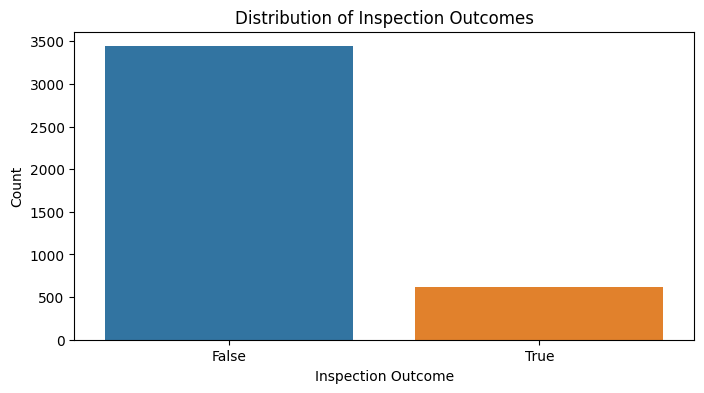

Inspection Outcome
False    3440
True      623
Name: count, dtype: int64

In [8]:
# Plot the distribution of the 'Inspection Outcome' column
plt.figure(figsize=(8, 4))
sns.countplot(x=df_original['Inspection Outcome'])
plt.title('Distribution of Inspection Outcomes')
plt.xlabel('Inspection Outcome')
plt.ylabel('Count')
plt.show()

# Display the counts of each outcome
df_original['Inspection Outcome'].value_counts()


In [9]:
from custom_transformers.lowercase_transformer import LowercaseTransformer

In [10]:
# Write code to train and serialize a model in the block below
#
# Outputs expected: `columns.json`, `dtypes.pickle` and `pipeline.pickle`
#
# Your pipeline should be able to receive a dataframe with the columns we've requested you to use
# in the form `pipeline.predict(test_df)`
#

# YOUR CODE HERE

target = 'Inspection Outcome'

all_features = [
    'Type',
    'Date',
    'Part of a standard enforcement protocol',
    'Galactic X', 
    'Galactic Y',
    'Reproduction',
    'Age range',
    'Self-defined species category',
    'Officer-defined species category',
    'Governing law',
    'Object of inspection',
    'Inspection involving more than just outerwear',
    'Enforcement station'
]

#numerical_features = ['Galactic X','Galactic Y']
numerical_features = ['Galactic X']


categorical_features = [
    'Type',
    'Part of a standard enforcement protocol',
    'Reproduction',
    'Age range',
    'Self-defined species category',
    'Officer-defined species category',
    'Governing law',
    'Object of inspection',
    'Inspection involving more than just outerwear',
    'Enforcement station'
]

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('lowercase', LowercaseTransformer(categorical_features)),
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)])

pipeline = make_pipeline(
    preprocessor,
    RandomForestClassifier(max_depth=3, min_samples_leaf=.03, class_weight="balanced", random_state=42, n_jobs=-1)
    #GradientBoostingClassifier(learning_rate=1.0, max_depth=7, n_estimators=100)
    #XGBClassifier(use_label_encoder=True, eval_metric='mlogloss')
    #LogisticRegression()
    #RandomForestClassifier(max_depth=10, min_samples_leaf=.03, class_weight="balanced", random_state=42, n_jobs=-1)
)


In [11]:
unique_values = get_unique_values(df_original[categorical_features])
unique_values

{'Type': ['Entity inspection',
  'Entity and Spaceship search',
  'Spaceship search'],
 'Part of a standard enforcement protocol': [False, nan, True],
 'Reproduction': ['Asexual', 'Sexual'],
 'Age range': ['Senior', 'Adult', 'Young Adult', 'Young', 'Child'],
 'Self-defined species category': ['Zoltrax - Diverse Clans',
  'Terran - Northern Cluster',
  'Xenar - Unspecified',
  'Terran - Outer Colonies',
  nan,
  'Terran - Gaelic Cluster',
  'Xenar - Diverse',
  'Silicar - Various Sects',
  'Zoltrax - Islander',
  'Zoltrax - Continental',
  'Silicar - Indusian',
  'Hybrid - Terran/Zoltrax',
  'Hybrid - Terran/Silicar',
  'Silicar - Banglorian',
  'Silicar - Pakterran',
  'Hybrid - Mixed Sects',
  'Hybrid - Terran/Zoltrax Continental',
  'Terran - Nomadic Tribes',
  'Silicar - Sino Sector'],
 'Officer-defined species category': ['Zoltrax',
  'Silicar',
  'Terran',
  'Xenar',
  'Hybrid'],
 'Governing law': ['Galactic Enforcement and Evidence Code 3984 (Clause 1)',
  'Interstellar Substance

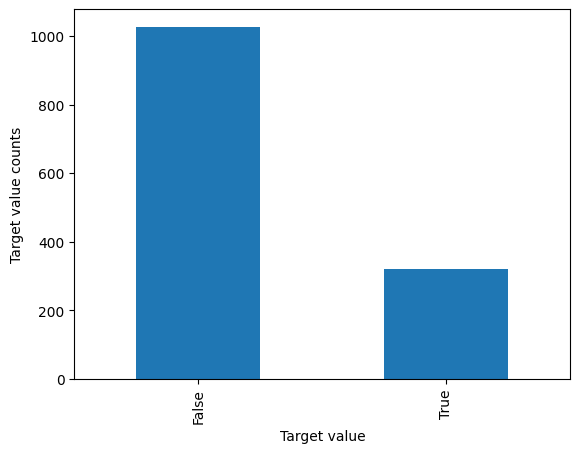

In [12]:
df_train, df_test = train_test_split(final_df, test_size=0.3, random_state=42)

df_test['Inspection Outcome'].value_counts().plot(kind="bar");
plt.xlabel('Target value');
plt.ylabel('Target value counts');

In [13]:
# This is a temporary directory where your serialized files will be saved. Make sure you use this as 
# the target folder when you serialize your files
TMP_DIR = ''

In [14]:
# Train data
X_train = df_train[all_features]
#y_train = df_train[target] == True
y_train = df_train[target]

# Fit the model
pipeline.fit(X_train, y_train)

# Test Data
X_test = df_test[all_features]
#y_test = df_test[target]  == True
y_test = df_test[target]

# Make Predictions
y_pred = pipeline.predict(X_test)
y_pred_train = pipeline.predict(X_train)

# Serialization

# Serialize the column names from the X DataFrame into a file named columns.json
# YOUR CODE HERE
with open(os.path.join(TMP_DIR, "columns.json"), 'w') as fh:
    json.dump(X_train.columns.tolist(), fh)

# Pickle the dtypes of the columns from the X DataFrame into a file named dtypes.pickle
# YOUR CODE HERE
with open(os.path.join(TMP_DIR,'dtypes.pickle'), 'wb') as fh:
    pickle.dump(X_train.dtypes, fh)
    
# Pickle the fitted pipeline into a file named pipeline.pickle
# YOUR CODE HERE
import joblib
joblib.dump(pipeline, os.path.join(TMP_DIR,'pipeline.pickle'))

# Baseline Scoring
roc_auc_score(y_test, y_pred)

0.7247510366521368

In [15]:
f1_score(y_test, y_pred)

0.5469904963041183

In [16]:
import sqlalchemy

username = 'postgres'
password = 'tsKVMTUOHtCZpVQYPtRbvkBdzmABPbDV'
host_name = 'roundhouse.proxy.rlwy.net'
port = 54090
db_name = 'railway'

conn_str = 'postgresql://{}:{}@{}:{}/{}'.format(username,password,host_name,port,db_name)
engine = sqlalchemy.create_engine(conn_str)
query = 'SELECT * FROM prediction;'
data_server = pd.read_sql_query(query, engine)

df = data_server.copy()
df_ = pd.DataFrame()
for i in range(len(df['observation'])):
    new = pd.DataFrame([json.loads(df['observation'][i])])
    df_=pd.concat([df_,new])
df_=df_.reset_index().drop(columns=['index'])
df_.head()

df_original['new'] = False
df_['new'] = True
concatenated_df = pd.concat([df_original, df_])
final_df = concatenated_df.drop_duplicates(subset='observation_id', keep='last')
final_df.set_index('observation_id', inplace = True)
final_df

/tmp/ipykernel_2938/2113166849.py:18: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_=pd.concat([df_,new])


,Type,Date,Part of a standard enforcement protocol,Galactic X,Galactic Y,Reproduction,Age range,Self-defined species category,Officer-defined species category,Governing law,Object of inspection,Inspection involving more than just outerwear,Enforcement station,Inspection Outcome,new
observation_id,,,,,,,,,,,,,,,
8ca4b11e-2814-42ab-b8e9-bf467d6f9bc1,Entity inspection,2239-12-14 13:22:00+00:00,False,8.528523,-1398.677772,Asexual,Senior,Zoltrax - Diverse Clans,Zoltrax,Galactic Enforcement and Evidence Code 3984 (C...,Vandalism Tools,NaN,Galactic Hub X101-IO,False,False
93930d11-d5cc-46a0-91eb-96fea69eea2f,Entity and Spaceship search,2241-06-07 14:00:00+00:00,False,23.330735,-3826.240540,Asexual,Adult,Zoltrax - Diverse Clans,Silicar,Interstellar Substance Control Ordinance 4719 ...,Regulated Star Substances,NaN,Galactic Hub X101-IO,False,False
b68b83bc-9eba-484b-9369-9707132592c8,Entity inspection,2241-09-17 15:30:00+00:00,NaN,-128.358204,21050.745456,Sexual,Adult,Terran - Northern Cluster,Terran,Interstellar Substance Control Ordinance 4719 ...,Regulated Star Substances,False,Helios Command C210-ZR,True,False
2bdea27c-2168-4884-9bda-68a862aea7e1,Entity and Spaceship search,2241-10-11 08:10:00+00:00,True,126.623742,-20766.293688,Asexual,Adult,Terran - Northern Cluster,Terran,Interstellar Substance Control Ordinance 4719 ...,Regulated Star Substances,False,Krypton Dock D175-WU,False,False
c8782f5f-1c50-4710-a129-d495a404c1c3,Entity and Spaceship search,2240-05-01 20:40:00+00:00,False,-23.578062,3866.802168,Asexual,Young Adult,Zoltrax - Diverse Clans,Zoltrax,Interstellar Substance Control Ordinance 4719 ...,Regulated Star Substances,NaN,Galactic Hub X101-IO,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4fa575f3-07ad-4572-96c4-a7b7444afa58,Entity inspection,2240-04-22 02:10:00+00:00,False,NaN,NaN,Asexual,Adult,Terran - Outer Colonies,Terran,Galactic Enforcement and Evidence Code 3984 (C...,Prohibited Combat Implements,None,Galactic Hub X101-IO,NaN,True
dc1a791f-f284-42b8-9a07-873850264e61,Entity inspection,2241-02-02 21:27:00+00:00,False,-21.399213,3509.470932,Sexual,Young Adult,Zoltrax - Diverse Clans,Zoltrax,Interstellar Substance Control Ordinance 4719 ...,Regulated Star Substances,None,Galactic Hub X101-IO,NaN,True
b05a7af2-bfbd-4cac-9f75-2b0a82726b48,Entity inspection,2241-06-06 12:05:00+00:00,False,-439.833411,72132.679404,Asexual,Adult,Terran - Northern Cluster,Terran,Galactic Enforcement and Evidence Code 3984 (C...,Prohibited Combat Implements,False,Graviton Manor Z54-VL,NaN,True


In [17]:
data_server.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 437 entries, 0 to 436
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              437 non-null    int64 
 1   observation_id  437 non-null    object
 2   observation     437 non-null    object
 3   label           437 non-null    bool  
dtypes: bool(1), int64(1), object(2)
memory usage: 10.8+ KB


In [18]:
df = data_server.copy()
df_ = pd.DataFrame()
for i in range(len(df['observation'])):
    new = pd.DataFrame([json.loads(df['observation'][i])])
    df_=pd.concat([df_,new])
df_=df_.reset_index().drop(columns=['index'])
df_.head()

/tmp/ipykernel_2938/2060346854.py:5: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_=pd.concat([df_,new])


,observation_id,Type,Date,Part of a standard enforcement protocol,Galactic X,Galactic Y,Reproduction,Age range,Self-defined species category,Officer-defined species category,Governing law,Object of inspection,Inspection involving more than just outerwear,Enforcement station
0,1f0fa837-323e-4942-9891-8465cfc5b94f,Entity inspection,2240-05-06 18:12:00+00:00,False,-5.556758,911.308312,Asexual,Young Adult,Xenar - Unspecified,Silicar,Universal Justice and Order Statute 3994 (Arti...,Hazardous Intimidation Devices,None,Galactic Hub X101-IO
1,429cd464-1bfa-48d3-b5b3-f77f682e3a0a,Entity inspection,2241-11-02 15:00:00+00:00,False,-4.638592,760.729088,Asexual,Adult,Zoltrax - Diverse Clans,Zoltrax,Interstellar Substance Control Ordinance 4719 ...,Regulated Star Substances,None,Galactic Hub X101-IO
2,ba5a5383-9001-4d76-9b49-fcdd0834f360,Entity inspection,2240-05-01 17:54:00+00:00,False,-15.627192,2562.859488,Asexual,Young,Zoltrax - Continental,Zoltrax,Galactic Enforcement and Evidence Code 3984 (C...,Confiscated Galactic Artifacts,None,Galactic Hub X101-IO
3,9c041168-9620-40ff-b528-bfa0c811b15c,Entity inspection,2241-11-13 20:20:00+00:00,None,-23.897700,3919.222800,Asexual,Young,Zoltrax - Continental,Zoltrax,Interstellar Substance Control Ordinance 4719 ...,Regulated Star Substances,False,Binary Transition Point L115-QE
4,c955cc5b-1523-4cce-a2aa-0a6415224782,Entity inspection,2240-10-14 03:00:00+00:00,False,18.292345,-2999.944580,Asexual,Young Adult,Terran - Northern Cluster,Terran,Galactic Enforcement and Evidence Code 3984 (C...,Proof of Interstellar Offenses,None,Galactic Hub X101-IO


In [19]:
df_original['new'] = False
df_['new'] = True
concatenated_df = pd.concat([df_original, df_])
final_df = concatenated_df.drop_duplicates(subset='observation_id', keep='last')
final_df.set_index('observation_id', inplace = True)
final_df

,Type,Date,Part of a standard enforcement protocol,Galactic X,Galactic Y,Reproduction,Age range,Self-defined species category,Officer-defined species category,Governing law,Object of inspection,Inspection involving more than just outerwear,Enforcement station,Inspection Outcome,new
observation_id,,,,,,,,,,,,,,,
8ca4b11e-2814-42ab-b8e9-bf467d6f9bc1,Entity inspection,2239-12-14 13:22:00+00:00,False,8.528523,-1398.677772,Asexual,Senior,Zoltrax - Diverse Clans,Zoltrax,Galactic Enforcement and Evidence Code 3984 (C...,Vandalism Tools,NaN,Galactic Hub X101-IO,False,False
93930d11-d5cc-46a0-91eb-96fea69eea2f,Entity and Spaceship search,2241-06-07 14:00:00+00:00,False,23.330735,-3826.240540,Asexual,Adult,Zoltrax - Diverse Clans,Silicar,Interstellar Substance Control Ordinance 4719 ...,Regulated Star Substances,NaN,Galactic Hub X101-IO,False,False
b68b83bc-9eba-484b-9369-9707132592c8,Entity inspection,2241-09-17 15:30:00+00:00,NaN,-128.358204,21050.745456,Sexual,Adult,Terran - Northern Cluster,Terran,Interstellar Substance Control Ordinance 4719 ...,Regulated Star Substances,False,Helios Command C210-ZR,True,False
2bdea27c-2168-4884-9bda-68a862aea7e1,Entity and Spaceship search,2241-10-11 08:10:00+00:00,True,126.623742,-20766.293688,Asexual,Adult,Terran - Northern Cluster,Terran,Interstellar Substance Control Ordinance 4719 ...,Regulated Star Substances,False,Krypton Dock D175-WU,False,False
c8782f5f-1c50-4710-a129-d495a404c1c3,Entity and Spaceship search,2240-05-01 20:40:00+00:00,False,-23.578062,3866.802168,Asexual,Young Adult,Zoltrax - Diverse Clans,Zoltrax,Interstellar Substance Control Ordinance 4719 ...,Regulated Star Substances,NaN,Galactic Hub X101-IO,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4fa575f3-07ad-4572-96c4-a7b7444afa58,Entity inspection,2240-04-22 02:10:00+00:00,False,NaN,NaN,Asexual,Adult,Terran - Outer Colonies,Terran,Galactic Enforcement and Evidence Code 3984 (C...,Prohibited Combat Implements,None,Galactic Hub X101-IO,NaN,True
dc1a791f-f284-42b8-9a07-873850264e61,Entity inspection,2241-02-02 21:27:00+00:00,False,-21.399213,3509.470932,Sexual,Young Adult,Zoltrax - Diverse Clans,Zoltrax,Interstellar Substance Control Ordinance 4719 ...,Regulated Star Substances,None,Galactic Hub X101-IO,NaN,True
b05a7af2-bfbd-4cac-9f75-2b0a82726b48,Entity inspection,2241-06-06 12:05:00+00:00,False,-439.833411,72132.679404,Asexual,Adult,Terran - Northern Cluster,Terran,Galactic Enforcement and Evidence Code 3984 (C...,Prohibited Combat Implements,False,Graviton Manor Z54-VL,NaN,True


In [20]:
data_server.drop('id', axis = 1, inplace = True)

In [21]:
#data_server.set_index('observation_id', inplace = True)
data_server['observation']

0      {"observation_id": "1f0fa837-323e-4942-9891-84...
1      {"observation_id": "429cd464-1bfa-48d3-b5b3-f7...
2      {"observation_id": "ba5a5383-9001-4d76-9b49-fc...
3      {"observation_id": "9c041168-9620-40ff-b528-bf...
4      {"observation_id": "c955cc5b-1523-4cce-a2aa-0a...
                             ...                        
432    {"observation_id": "4fa575f3-07ad-4572-96c4-a7...
433    {"observation_id": "dc1a791f-f284-42b8-9a07-87...
434    {"observation_id": "b05a7af2-bfbd-4cac-9f75-2b...
435    {"observation_id": "df19e5e4-8103-4f13-9b03-a2...
436    {"observation_id": "8525028a-844a-40d7-aa7f-e5...
Name: observation, Length: 437, dtype: object

In [22]:
data_server = data_server.join(pd.json_normalize(data_server.pop('observation')))
data_server

,observation_id,label
0,1f0fa837-323e-4942-9891-8465cfc5b94f,False
1,429cd464-1bfa-48d3-b5b3-f77f682e3a0a,True
2,ba5a5383-9001-4d76-9b49-fcdd0834f360,True
3,9c041168-9620-40ff-b528-bfa0c811b15c,True
4,c955cc5b-1523-4cce-a2aa-0a6415224782,True
...,...,...
432,4fa575f3-07ad-4572-96c4-a7b7444afa58,True
433,dc1a791f-f284-42b8-9a07-873850264e61,True
434,b05a7af2-bfbd-4cac-9f75-2b0a82726b48,True
435,df19e5e4-8103-4f13-9b03-a2892ac9cd2f,True


In [25]:
# Calculate accuracy for each subgroup defined by sensitive attributes
accuracy_species = {}
accuracy_reproduction = {}

# Group by 'Self-defined species category' and 'Reproduction', calculate accuracy for each group
for group_col in ['Self-defined species category', 'Reproduction']:
    for group_val in X_test[group_col].unique():
        mask = X_test[group_col] == group_val
        accuracy = accuracy_score(y_test[mask], y_pred[mask])
        if group_col == 'Self-defined species category':
            accuracy_species[group_val] = accuracy
        else:
            accuracy_reproduction[group_val] = accuracy

# Calculate discrepancy in accuracy between subgroups
discrepancy_species = max(accuracy_species.values()) - min(accuracy_species.values())
discrepancy_reproduction = max(accuracy_reproduction.values()) - min(accuracy_reproduction.values())

# Check if the maximum allowable difference in accuracy is exceeded
max_discrepancy = 0.15
if discrepancy_species <= max_discrepancy and discrepancy_reproduction <= max_discrepancy:
    print("Model does not exhibit discrepancies in prediction accuracy based on species type or reproduction.")
    print("Discrepancy in accuracy (species):", discrepancy_species)
    print("Discrepancy in accuracy (reproduction):", discrepancy_reproduction)
else:
    print("Model exhibits discrepancies in prediction accuracy based on species type or reproduction.")
    print("Discrepancy in accuracy (species):", discrepancy_species)
    print("Discrepancy in accuracy (reproduction):", discrepancy_reproduction)

Model exhibits discrepancies in prediction accuracy based on species type or reproduction.
Discrepancy in accuracy (species): 0.5
Discrepancy in accuracy (reproduction): 0.1568753915895773


/home/ricky/.virtualenvs/s06/lib/python3.10/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/ricky/.virtualenvs/s06/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [24]:
error = 

SyntaxError: invalid syntax (3026150132.py, line 1)

In [ ]:
import os
import pandas as pd
import json
import joblib
import pickle
import requests
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
# Define a dictionary of models with their respective parameter grids for hyperparameter tuning
models = {
    'Logistic Regression': {
        'model': LogisticRegression(),
        'params': {
            'classifier__C': [0.1, 1.0, 10.0],
            'classifier__penalty': ['l1', 'l2']
        }
    },
    'Decision Tree': {
        'model': DecisionTreeClassifier(),
        'params': {
            'classifier__max_depth': [None, 5, 10, 20],
            'classifier__min_samples_split': [2, 5, 10],
            'classifier__min_samples_leaf': [1, 2, 4]
        }
    },
    'Random Forest': {
        'model': RandomForestClassifier(),
        'params': {
            'classifier__n_estimators': [100, 200, 300],
            'classifier__max_depth': [None, 5, 10, 20],
            'classifier__min_samples_split': [2, 5, 10],
            'classifier__min_samples_leaf': [1, 2, 4],
            'classifier__bootstrap': [True, False]
        }
    },
    'Support Vector Machine': {
        'model': SVC(),
        'params': {
            'classifier__C': [0.1, 1.0, 10.0],
            'classifier__kernel': ['linear', 'rbf']
        }
    },
    'AdaBoost': {
        'model': AdaBoostClassifier(),
        'params': {
            'classifier__n_estimators': [50, 100, 200],
            'classifier__learning_rate': [0.01, 0.1, 1.0]
        }
    },
    'Gradient Boosting': {
        'model': GradientBoostingClassifier(),
        'params': {
            'classifier__n_estimators': [50, 100, 200],
            'classifier__learning_rate': [0.01, 0.1, 1.0],
            'classifier__max_depth': [3, 5, 7]
        }
    },
    'K-Nearest Neighbors': {
        'model': KNeighborsClassifier(),
        'params': {
            'classifier__n_neighbors': [3, 5, 7],
            'classifier__weights': ['uniform', 'distance']
        }
    },
    'Multi-layer Perceptron': {
        'model': MLPClassifier(),
        'params': {
            'classifier__hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50, 25)],
            'classifier__activation': ['logistic', 'relu'],
            'classifier__alpha': [0.0001, 0.001, 0.01]
        }
    }
}
# Test each model using grid search for hyperparameter tuning
for name, model_info in models.items():
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', model_info['model'])])
    grid_search = GridSearchCV(pipeline, model_info['params'], cv=5, scoring='f1')
    grid_search.fit(X_train, y_train)
    print(f'Best parameters for {name}: {grid_search.best_params_}')
    print(f'F1 Score: {grid_search.best_score_}')